# CNN with Bounding Boxes

### Start of execution

In [1]:
import time

In [2]:
start = time.time()

# 1. Import Libraries

In [3]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from keras import Model
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.optimizers import Adam
from keras.backend import epsilon
import matplotlib.patches as patches
from keras.layers import Conv2D, Reshape
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback

# 2. Preparation

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
IMAGE_SIZE = 128
ALPHA = 1.0

In [6]:
data_path = 'drive/MyDrive/Profesional_Academico/Github_Personal/ML_AI_Contents/09.Deep_Learning/83.CNN_Bounding_Boxes/data'

# 3. Functions

In [7]:
def loss(gt, pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

In [8]:
def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

# 4. Load data and creation of batches

In [9]:
data = pd.read_csv(f"{data_path}/train_labels_.csv")

In [10]:
data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [11]:
coords = data[["width","height","xmin","ymin","xmax","ymax"]]

coords["xmin"] = coords["xmin"] *IMAGE_SIZE/coords["width"]
coords["xmax"] = coords["xmax"]*IMAGE_SIZE /coords["width"]
coords["ymin"] = coords["ymin"] *IMAGE_SIZE/coords["height"]
coords["ymax"] = coords["ymax"] *IMAGE_SIZE/coords["height"]

coords.drop(["width","height"],axis =1,inplace=True)
coords.head()

<ipython-input-11-0b5c5a0c2b38>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coords["xmin"] = coords["xmin"] *IMAGE_SIZE/coords["width"]
<ipython-input-11-0b5c5a0c2b38>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coords["xmax"] = coords["xmax"]*IMAGE_SIZE /coords["width"]
<ipython-input-11-0b5c5a0c2b38>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

,xmin,ymin,xmax,ymax
0,46.949807,39.587629,82.532819,77.855670
1,0.581818,0.296296,89.406061,127.703704
2,15.786667,34.240000,59.733333,92.800000
3,48.426667,29.760000,85.973333,95.360000
4,27.194139,22.832432,92.366300,87.870270


In [12]:
paths = data["filename"]
len(paths)

173

In [13]:
images = f'{data_path}/Racoon Images/images/'

In [14]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE,3), dtype=np.float32)

for i, f in enumerate(paths):

  img = Image.open(images+f)
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = img.convert('RGB')
  batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

# 5. Load model

In [15]:
model = MobileNet(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, alpha = ALPHA)

In [16]:
for layers in model.layers:
  layers.trainable = False

x = model.layers[-1].output
x = Conv2D(4, kernel_size = 4, name="coords")(x)
x = Reshape((4,))(x)

model = Model(inputs = model.inputs, outputs = x)

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 64, 64, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 64, 64, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 64, 64, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 65, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 32, 32, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 32, 32, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 32, 32, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 32, 32, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,294,404 (12.57 MB)

 Trainable params: 65,540 (256.02 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [18]:
len(batch_images)

173

# 6. Preparation to train

In [19]:
gt = coords

In [20]:
gt_train = gt[0:120]
gt_val = gt[120:]

In [21]:
batch_images_train = batch_images[0:120]
batch_images_val = batch_images[120:]

# 7. Training

In [22]:
n_epochs = 2_000

In [23]:
model.compile(optimizer = Adam(learning_rate = 1e-5), loss = "mse")

In [24]:
hist = model.fit(batch_images_train, gt_train, validation_data = (batch_images_val, gt_val), epochs = n_epochs, verbose = 2)

Epoch 1/2000
4/4 - 11s - 3s/step - loss: 6361.4165 - val_loss: 6199.6729
Epoch 2/2000
4/4 - 0s - 22ms/step - loss: 6308.9219 - val_loss: 6147.3506
Epoch 3/2000
4/4 - 0s - 24ms/step - loss: 6257.8262 - val_loss: 6095.4805
Epoch 4/2000
4/4 - 0s - 21ms/step - loss: 6206.6665 - val_loss: 6044.2407
Epoch 5/2000
4/4 - 0s - 21ms/step - loss: 6155.9531 - val_loss: 5993.4976
Epoch 6/2000
4/4 - 0s - 20ms/step - loss: 6105.6787 - val_loss: 5943.1680
Epoch 7/2000
4/4 - 0s - 22ms/step - loss: 6056.0581 - val_loss: 5893.2832
Epoch 8/2000
4/4 - 0s - 23ms/step - loss: 6006.6494 - val_loss: 5843.9536
Epoch 9/2000
4/4 - 0s - 21ms/step - loss: 5958.4946 - val_loss: 5794.9658
Epoch 10/2000
4/4 - 0s - 21ms/step - loss: 5909.6646 - val_loss: 5746.5435
Epoch 11/2000
4/4 - 0s - 21ms/step - loss: 5862.0303 - val_loss: 5698.5703
Epoch 12/2000
4/4 - 0s - 22ms/step - loss: 5814.2603 - val_loss: 5651.1733
Epoch 13/2000
4/4 - 0s - 22ms/step - loss: 5767.4888 - val_loss: 5604.1807
Epoch 14/2000
4/4 - 0s - 21ms/step 

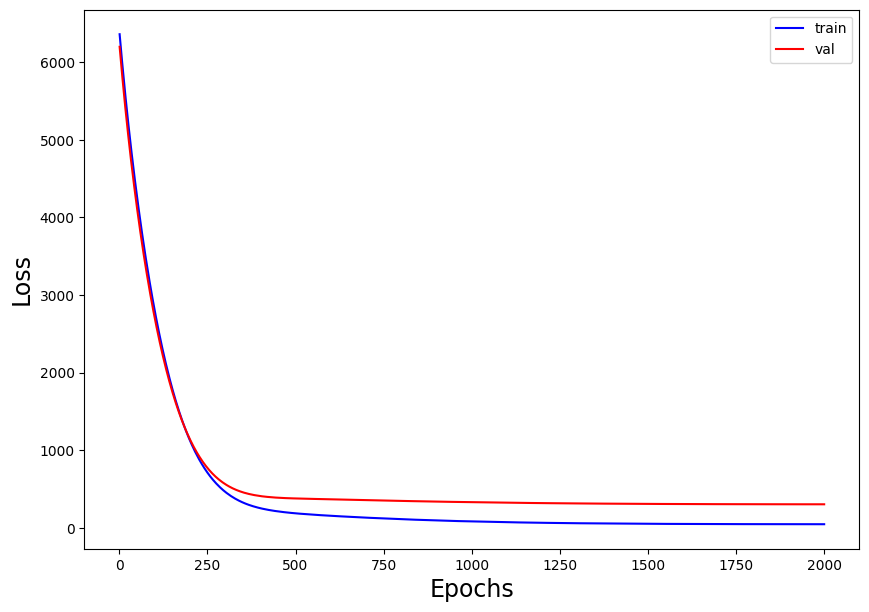

In [25]:
plt.figure(figsize = (10, 7))

plt.plot([i for i in range(1, n_epochs + 1)], hist.history['loss'], color = 'blue', label = 'train')
plt.plot([i for i in range(1, n_epochs + 1)], hist.history['val_loss'], color = 'red', label = 'val')

plt.xlabel('Epochs', fontsize = 17)
plt.ylabel('Loss', fontsize = 17)

plt.legend()
plt.show()

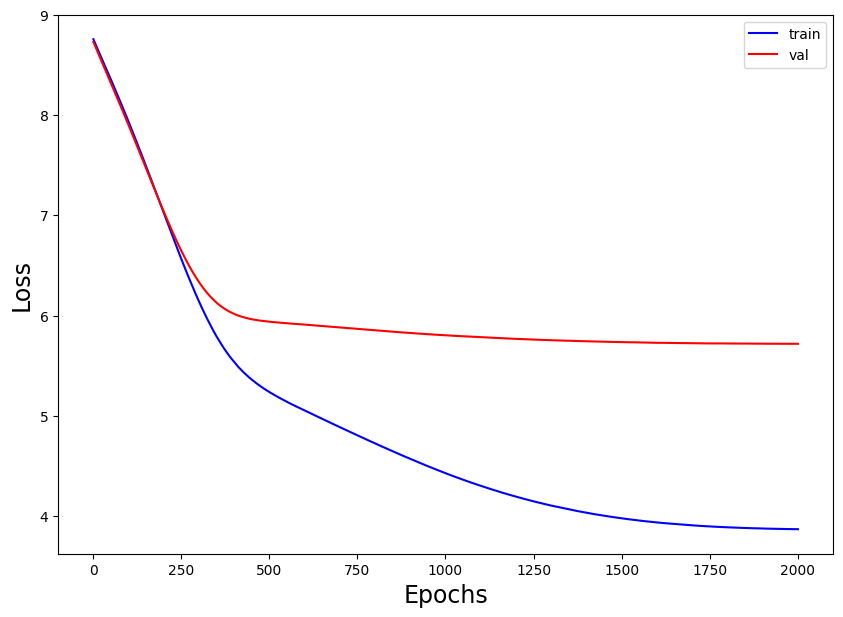

In [26]:
plt.figure(figsize = (10, 7))

plt.plot([i for i in range(1, n_epochs + 1)], np.log(np.array(hist.history['loss'])), color = 'blue', label = 'train')
plt.plot([i for i in range(1, n_epochs + 1)], np.log(np.array(hist.history['val_loss'])), color = 'red', label = 'val')

plt.xlabel('Epochs', fontsize = 17)
plt.ylabel('Loss', fontsize = 17)

plt.legend()
plt.show()

# 8. Inference

### a. Train

In [27]:
train_img = paths.iloc[0]

In [28]:
filename = images + train_img
print(filename)
unscaled = cv2.imread(filename)

drive/MyDrive/Profesional_Academico/Github_Personal/ML_AI_Contents/09.Deep_Learning/83.CNN_Bounding_Boxes/data/Racoon Images/images/raccoon-17.jpg


In [29]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled,(IMAGE_SIZE,IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [30]:
region = model.predict(x = np.array([feat_scaled]))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [31]:
x0 = int(region[0] * image_width / IMAGE_SIZE)
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

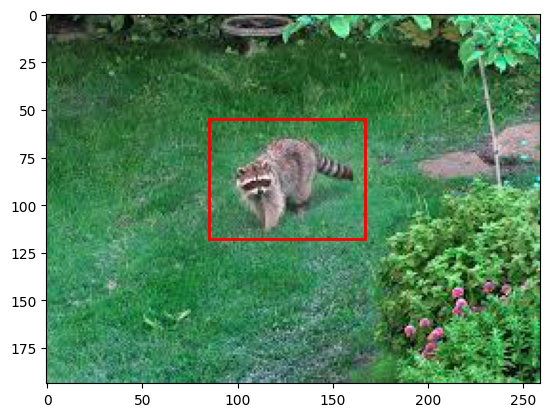

In [32]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

### b. Test

In [33]:
test_img = paths.iloc[-1]

In [34]:
filename = images + test_img
print(filename)
unscaled = cv2.imread(filename)

drive/MyDrive/Profesional_Academico/Github_Personal/ML_AI_Contents/09.Deep_Learning/83.CNN_Bounding_Boxes/data/Racoon Images/images/raccoon-152.jpg


In [35]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled,(IMAGE_SIZE,IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [36]:
region = model.predict(x = np.array([feat_scaled]))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [37]:
x0 = int(region[0] * image_width / IMAGE_SIZE)
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

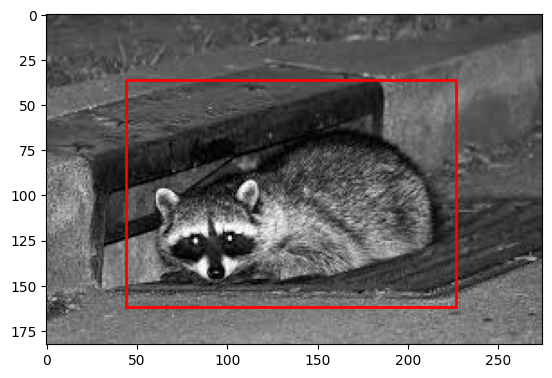

In [38]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

### End of execution

In [39]:
end = time.time()

delta = (end - start)

hours = int(delta/3_600)
mins = int((delta - hours*3_600)/60)
secs = int(delta - hours*3_600 - mins*60)

print(f'Hours: {hours}, Minutes: {mins}, Seconds: {secs}')

Hours: 0, Minutes: 3, Seconds: 19
